# End-to-end multi-class dog breed classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we are using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are a 120 breeds of dogs (120 different classes)
* There are around +10,000 images in the training set (these images have labels)
* There are around +10,000 images in the test set (these images have no labels, because we'll want to predict them)

### Get our workspace ready
https://www.tensorflow.org/install/pip#windows-native_1

- First we need to install the Nvidia CUDA toolkits in the PC. (we need to check which version supports our GPU)
- Then we download and put in their directories the cuDNN files and we assign the PATH variables.
- Lastly we go to the Tensorflow webpage and follow the instructions to install Tensorflow with Pip and else.

This project is being done with:

* CUDA 11.2
* cuDNN 11.2 - version 8.1.0
* TensorFlow 2.10
* Python 3.10

In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU", "available (YES!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.10.1
TF Hub version: 0.15.0
Num GPUs Available:  1
GPU available (YES!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the tables.

In [2]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("data/labels.csv")
labels_csv.describe(), labels_csv.head()

(                                      id               breed
 count                              10222               10222
 unique                             10222                 120
 top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
 freq                                   1                 126,
                                  id             breed
 0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
 1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
 2  001cdf01b096e06d78e9e5112d419397          pekinese
 3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
 4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever)

<Axes: xlabel='breed'>

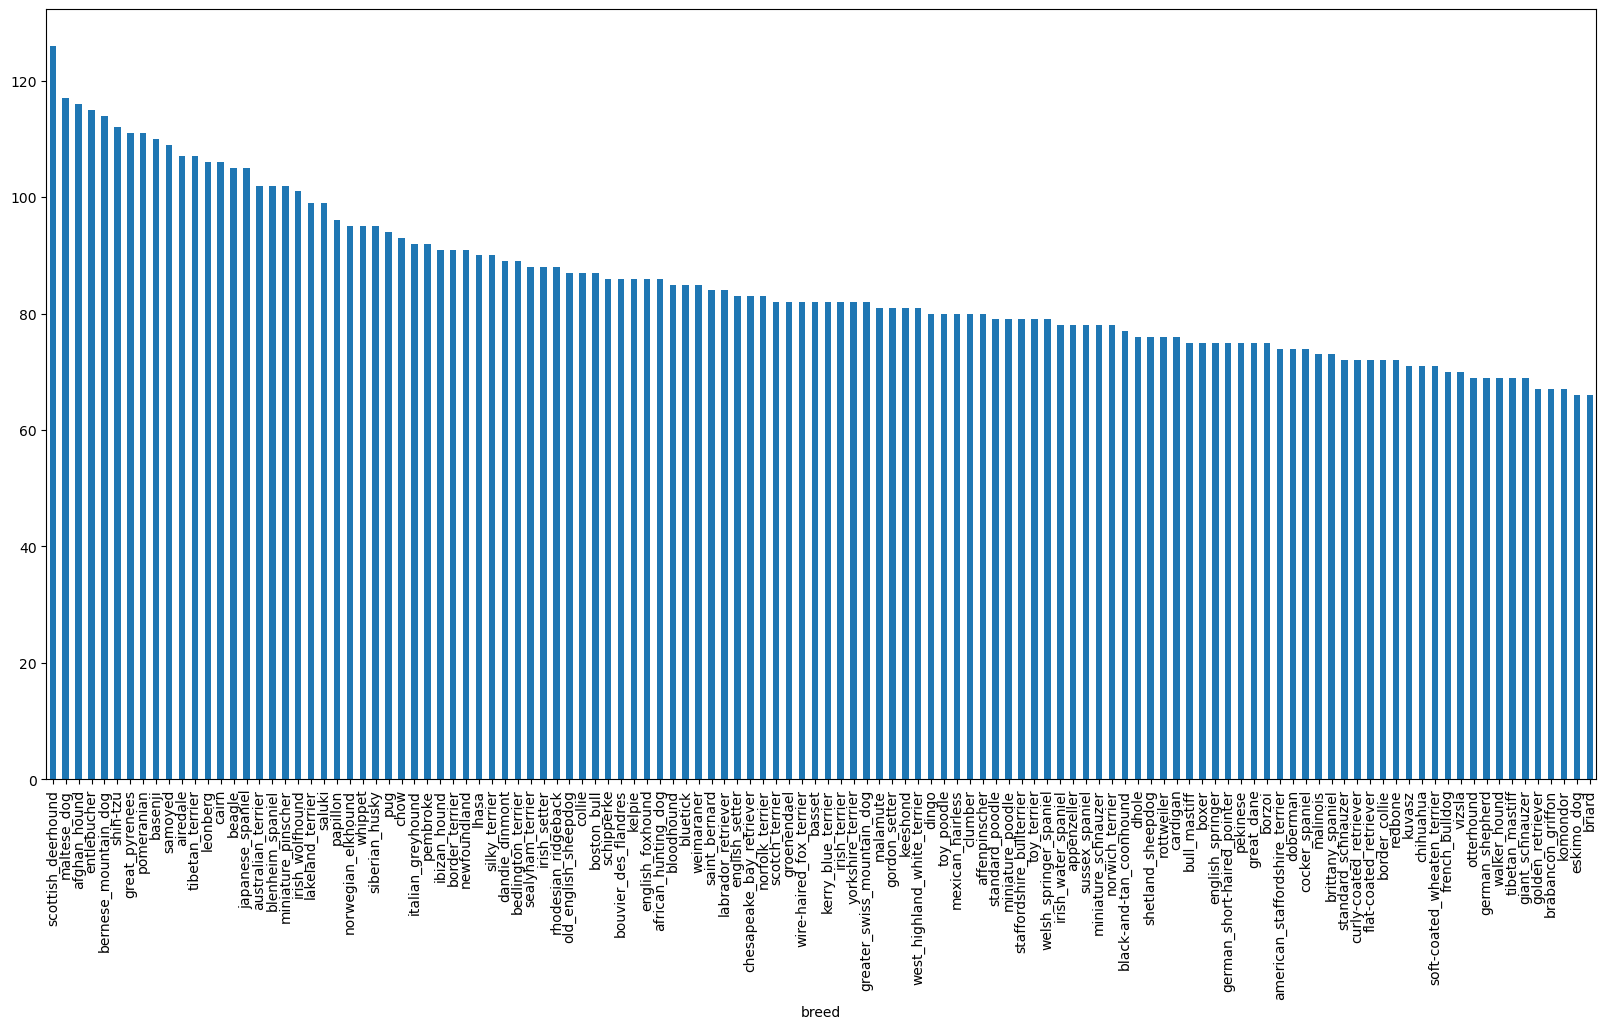

In [3]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [4]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()
# Google recommends a 10 of minimum per label

82.0

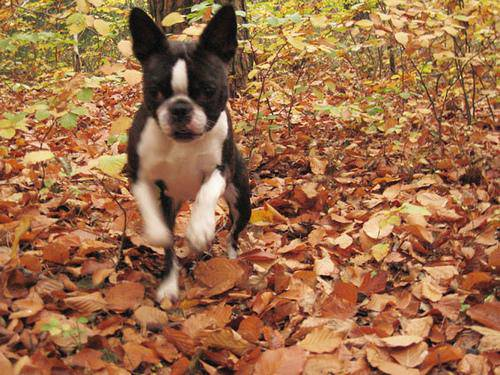

In [5]:
# Let's view an image
from IPython.display import Image
Image("data/train/000bec180eb18c7604dcecc8fe0dba07.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [6]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [7]:
# Create pathnames from image ID's
filenames = ["data/train/" + fname + ".jpg" for fname in labels_csv["id"]]

# Check the first 10
filenames[:10]

['data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'data/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'data/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'data/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'data/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
# Check whether number of filenames matches number of actual image files
import os
train_files_count = len(os.listdir("data/train"))
filenames_count = len(filenames)
if train_files_count == filenames_count:
    print(f"Count: {train_files_count} out of {filenames_count}")
    print("Filenames match actual amount of files! Proceed.")
else:
    print(f"Count: {train_files_count} out of {filenames_count}")
    print("Error: Filename count does not match the actual filecount!, check the target directory")

Count: 10222 out of 10222
Filenames match actual amount of files! Proceed.


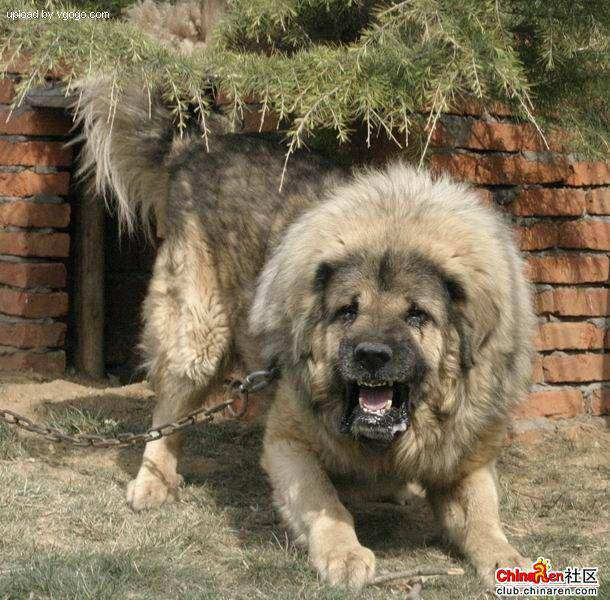

In [9]:
# One more check
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, let´s prepare our labels.

In [11]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [12]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
    print("Number of labels matches number of filenames!")
else:
    print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [13]:
len(labels)

10222

In [14]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [15]:
len(unique_breeds)

120

We have 120 breeds of dogs

In [16]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds
# This code returns an array of true and false values where everywhere on unique breeds labels[0] doesn't equal should be False. 
# But the only location where does equal should be True.

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [17]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [18]:
len(boolean_labels)

10222

In [19]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [20]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [21]:
# Setup X & y variables
X = filenames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [22]:
import ipywidgets as widgets
# Set the number of images to use for experimenting
NUM_IMAGES = widgets.IntSlider(min=1000, max=10000, step=1000, value=1000)

In [23]:
display(NUM_IMAGES)

IntSlider(value=1000, max=10000, min=1000, step=1000)

In [24]:
# Let's split our data into train and validation sets (test set not yet)
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES.value],
                                                  y[:NUM_IMAGES.value],
                                                  test_size=0.2, # here test size is our validation data size.
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [25]:
# Let's have a little look at the training data
X_train[:3], y_train[:3]

(['data/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'data/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'data/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, Fals

## Preprocessing images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [26]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

Returns us the height, width and color channel (RGB)

In [27]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

Returns us the color pixels values

In [28]:
# Turn image into a tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.
1. Take an image filepath as input.
2. Use Tensorflow to read the file and save it to a variable `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our `image` (convert color channel values from 0-225 to 0-1)
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [29]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
    """
    Takes an image file path and turns the image into a Tensor.
    """
    # Read in an image file
    image = tf.io.read_file(image_path)
    # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
    image = tf.image.decode_jpeg(image, channels=3)
    # Convert the color channel values from 0-255 to 0-1 values
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to our desired value (244,244)
    image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

    return image


------
Just to know what we just did in the function

In [30]:
tensor = tf.io.read_file(filenames[26])
tensor

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xf4\x01w\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [31]:
tf.image.decode_jpeg(tensor, channels=3)

<tf.Tensor: shape=(500, 375, 3), dtype=uint8, numpy=
array([[[ 59,  68,  65],
        [ 64,  73,  70],
        [ 71,  80,  77],
        ...,
        [115, 128, 108],
        [115, 128, 108],
        [110, 123, 103]],

       [[ 65,  74,  71],
        [ 72,  81,  78],
        [ 79,  88,  85],
        ...,
        [114, 127, 107],
        [117, 130, 110],
        [116, 129, 109]],

       [[ 68,  77,  74],
        [ 76,  85,  82],
        [ 83,  92,  89],
        ...,
        [114, 127, 107],
        [120, 133, 113],
        [123, 136, 116]],

       ...,

       [[173, 200, 155],
        [164, 179, 136],
        [181, 166, 133],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[142, 159, 117],
        [147, 154, 113],
        [189, 174, 141],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[167, 179, 139],
        [167, 172, 132],
        [204, 188, 155],
        ...,
        [255, 255, 25

In [32]:
tensor = tf.image.decode_jpeg(tensor, channels=3)
tf.image.convert_image_dtype(tensor, tf.float32)

<tf.Tensor: shape=(500, 375, 3), dtype=float32, numpy=
array([[[0.23137257, 0.26666668, 0.25490198],
        [0.2509804 , 0.28627452, 0.27450982],
        [0.2784314 , 0.3137255 , 0.3019608 ],
        ...,
        [0.45098042, 0.5019608 , 0.42352945],
        [0.45098042, 0.5019608 , 0.42352945],
        [0.43137258, 0.48235297, 0.4039216 ]],

       [[0.25490198, 0.2901961 , 0.2784314 ],
        [0.28235295, 0.31764707, 0.30588236],
        [0.30980393, 0.34509805, 0.33333334],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.45882356, 0.50980395, 0.43137258],
        [0.454902  , 0.5058824 , 0.427451  ]],

       [[0.26666668, 0.3019608 , 0.2901961 ],
        [0.29803923, 0.33333334, 0.32156864],
        [0.3254902 , 0.36078432, 0.34901962],
        ...,
        [0.44705886, 0.49803925, 0.41960788],
        [0.47058827, 0.52156866, 0.4431373 ],
        [0.48235297, 0.53333336, 0.454902  ]],

       ...,

       [[0.6784314 , 0.7843138 , 0.60784316],
        [0.64

------

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process +10,000 images in one go... they all might not fit into memory.

So that's why we do about 32 images at a time (you can manually adjust the batch size if needed).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples, which looks like this: `(image, label)`.

In [33]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
    """
    Takes an image file path name and the associated label,
    processes the image and returns a tuple of (image, label)
    """
    image = process_image(image_path)
    return image, label

-------
Demo of the above

In [34]:
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

--------

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [35]:
# Define the btach size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn our data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    """
    Creates batches of data out of image (X) and label (y) pairs.
    Shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels).
    """
    # If the data is a test dataset, we probably don't have labels.
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # Only filepaths (no labels)
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a valid dataset, we don't need to shuffle it
    elif valid_data:
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        return data_batch
    
    # If the data is a training dataset, we are gonna create a training batch
    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                                   tf.constant(y))) # labels
        # Shuffling pathnames and labels before mapping image processor function is faster than suffling images.
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the image path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(BATCH_SIZE)
    
    return data_batch

In [36]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [37]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec 

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend, let's visualize them!

In [38]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
    """
    Displays a plot of 25 images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10, 10))
    # Loop through 25 (for displaying 25 images)
    for i in range(25):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5,5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add the image label as the title
        plt.title(unique_breeds[labels[i].argmax()])
        # Turn the grid lines off
        plt.axis("off")

The data is in a batch, so we need to essentially un-batch it to visualize it

In [39]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

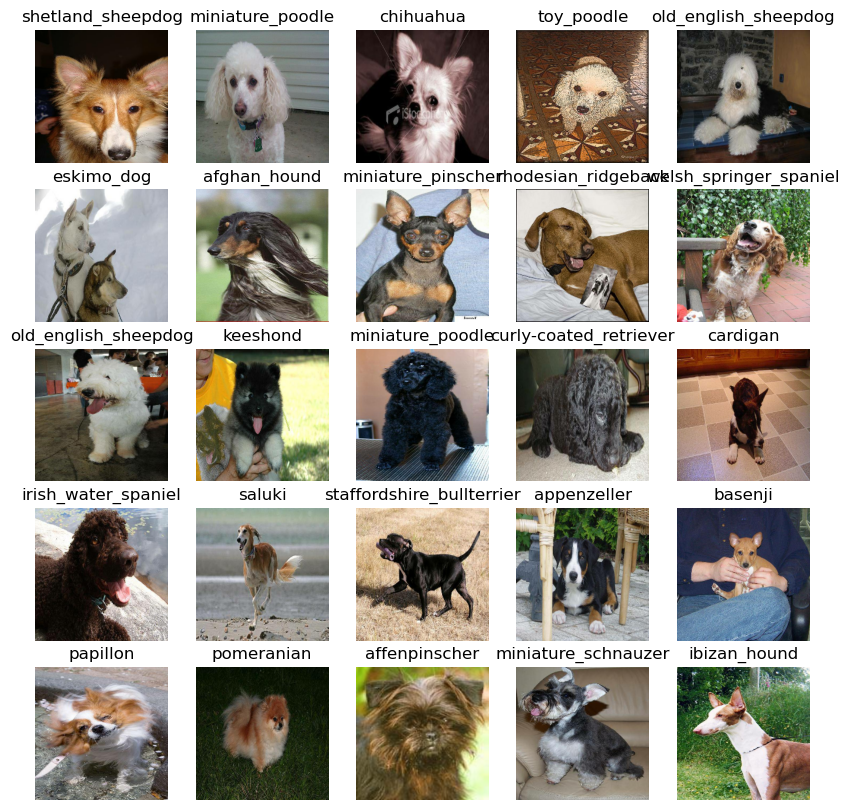

In [40]:
train_images, train_labels = next(train_data.as_numpy_iterator() # we un-batch the train data, turning it into an iterator
                                  ) # with next we take a batch off the top
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

# every time we call the training batch is gonna shuffle the data
# because of the create_data_batches() function

In [41]:
train_images, train_labels

(array([[[[1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          ...,
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03],
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03],
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03]],
 
         [[1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          ...,
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03],
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03],
          [5.09803966e-02, 3.13725509e-02, 7.84313772e-03]],
 
         [[1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          [1.17647070e-02, 1.56862754e-02, 0.00000000e+00],
          ...,
          [5.09803966e-02, 3.13725509e-02, 7.8431

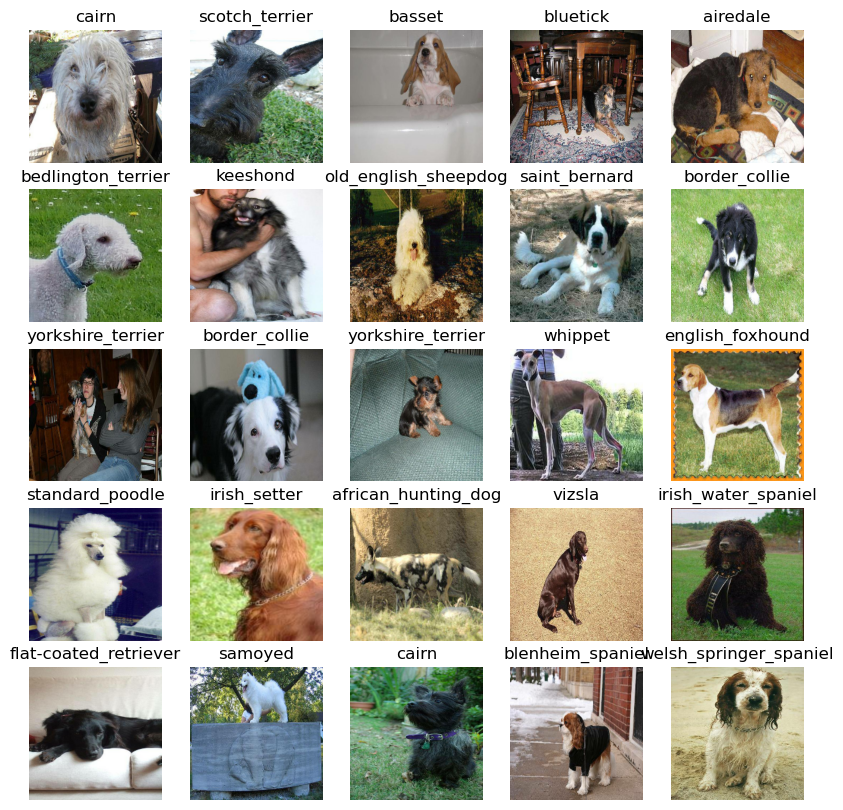

In [42]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use from Tensorflow Hub: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [43]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be getting).
* Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [44]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    print("Building model with:", MODEL_URL)

    # Setup the model layers
    model = tf.keras.Sequential(
        [
            hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
            tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                  activation="softmax") # Layer 2 (output layer)
        ]
    )

    # Compile the model
    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )

    # Build the model
    model.build(INPUT_SHAPE)

    return model

In [45]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving (there are more things that can do, but we are going to implement just those ones).

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard callback
1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize our models training logs with the `%tensorboard` magic function (we'll do this after model training).

In [46]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [47]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
    # Get the directory name of the current file
    # current_dir = os.path.dirname(os.path.abspath(__file__))

    # Create a log directory for storing TensorBoard logs
    #logdir = os.path.join(f"{current_dir}/logs",
                          # Make it so the logs get tracked whenever we run an experiment
                          #datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
                          #)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

    return tf.keras.callbacks.TensorBoard(log_dir=logdir)

### Early Stopping Callback

Early stopping helps our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [56]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_categorical_accuracy",
                                                  patience=3)

## Training a model (on a subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working.

In [57]:
# Set the number of images to use for experimenting
NUM_EPOCHS = widgets.IntSlider(min=10, max=100, step=10, value=100)

In [58]:
display(NUM_EPOCHS)

IntSlider(value=100, min=10, step=10)

An epoch in deep learning represents one complete cycle of training where the model is updated using the entire training dataset, and multiple epochs are typically used to train the model until it converges to a satisfactory level of performance.

The number of epochs is a hyperparameter that the data scientist or machine learning engineer needs to specify when training a neural network. Choosing the right number of epochs is crucial, as too few epochs may result in underfitting (the model doesn't learn the data patterns well), while too many epochs can lead to overfitting (the model memorizes the training data and performs poorly on new, unseen data).



In [59]:
# Check to make sure we're still running on a GPU

# Get the list of available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if not gpus:
    print("No GPU devices found. TensorFlow is using CPU.")
else:
    for gpu in gpus:
        print(f"GPU device: {gpu.name}")

GPU device: /physical_device:GPU:0


Let's create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for (NUM_EPOCHS) and the callbacks we'd like to use
* Return the model

In [60]:
# Build a function to train and return a trained model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create model
    model = create_model()

    # Create new TensorBoard session everytime we train a model
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    model.fit(x=train_data, 
              epochs=NUM_EPOCHS.value, 
              validation_data=val_data, 
              validation_freq=1, 
              callbacks=[tensorboard, early_stopping])

    # Return the fitted model
    return model

In [61]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


Epoch 1/100
25/25 [==============================] - 12s 167ms/step - loss: 4.5993 - categorical_accuracy: 0.1063 - val_loss: 3.5408 - val_categorical_accuracy: 0.2400
Epoch 2/100
25/25 [==============================] - 3s 133ms/step - loss: 1.6137 - categorical_accuracy: 0.6812 - val_loss: 2.2045 - val_categorical_accuracy: 0.5300
Epoch 3/100
25/25 [==============================] - 3s 129ms/step - loss: 0.5473 - categorical_accuracy: 0.9388 - val_loss: 1.7469 - val_categorical_accuracy: 0.5950
Epoch 4/100
25/25 [==============================] - 3s 131ms/step - loss: 0.2452 - categorical_accuracy: 0.9875 - val_loss: 1.5292 - val_categorical_accuracy: 0.6350
Epoch 5/100
25/25 [==============================] - 3s 131ms/step - loss: 0.1444 - categorical_accuracy: 0.9975 - val_loss: 1.4458 - val_categorical_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 3s 130ms/step - loss: 0.0993 - categorical_accuracy: 1.0000 - val_loss: 1.4065 - val_categorical_accuracy: 0.65

**Question:** It looks like our model is overfitting because it's performing far better on the training dataset than the validation dataset, what are some ways to prevent model overfitting in deep learning neural networks?